# Online Retail K-means & Hierarchical Clustering

## Contexto
O varejo on-line é um conjunto de dados transnacionais que contém todas as transações ocorridas entre 12/01/2010 e 12/09/2011 para um varejo on-line sem loja registrado e com sede no Reino Unido. A empresa vende principalmente presentes exclusivos para todas as ocasiões. Muitos clientes da empresa são atacadistas.

## Meta de negócios
Usaremos o conjunto de dados transnacionais de varejo on-line para construir um cluster RFM e escolher o melhor conjunto de clientes que a empresa deve atingir.

A análise RFM é uma metodologia de segmentação de clientes que agrupa consumidores com base em três critérios: Recência, Frequência e Valor Gasto (Monetário)

# Download

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hellbuoy/online-retail-customer-clustering")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hellbuoy/online-retail-customer-clustering/versions/1


# Execução

# Carregar dados

In [ ]:
import pandas as pd
data = pd.read_excel('/content/OnlineRetail.xlsx')

## Criar variáveis de recência e frequência

In [ ]:
data.head()

,InvoiceNo,Invoiceno,StockCode,Stockvcode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,536365,85123.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,536365,71053.0,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,536365,84406.0,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,536365,84029.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,536365,84029.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
data = data.drop("Invoiceno", axis=1)
data = data.drop("Stockvcode", axis=1)

# Calcular a Recência
# 1. Converter 'InvoiceDate' para datetime, caso ainda não esteja no formato
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 2. Definir uma data de referência para calcular a recência (a última data do conjunto de dados)
reference_date = data['InvoiceDate'].max()

# 3. Calcular a recência como o número de dias desde a última compra até a data de referência
recency = data.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (reference_date - x).days)
recency = recency.rename('Recency')

# Calcular a Frequência
# 4. Contar o número de transações (InvoiceNo) por cliente
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique()
frequency = frequency.rename('Frequency')

# Calcular o Valor Monetário
# 5. Calcular o valor total gasto (somatório de 'TotalPurchase' ou de 'Quantity' * 'UnitPrice') por cliente
data['TotalPurchase'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby('CustomerID')['TotalPurchase'].sum()
monetary = monetary.rename('Monetary')

# Criar o DataFrame RFM com as três variáveis calculadas
rfm = pd.DataFrame({'Recency': recency, 'Frequency': frequency, 'Monetary': monetary})

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPurchase
0,536365,85123.0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053.0,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406.0,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029.0,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029.0,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


## APLICAÇÃO PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
# Variáveis quantitativas para a análise de cluster
quantitative_data = rfm[['Recency', 'Frequency', 'Monetary']]

# Padronizar os dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(quantitative_data)

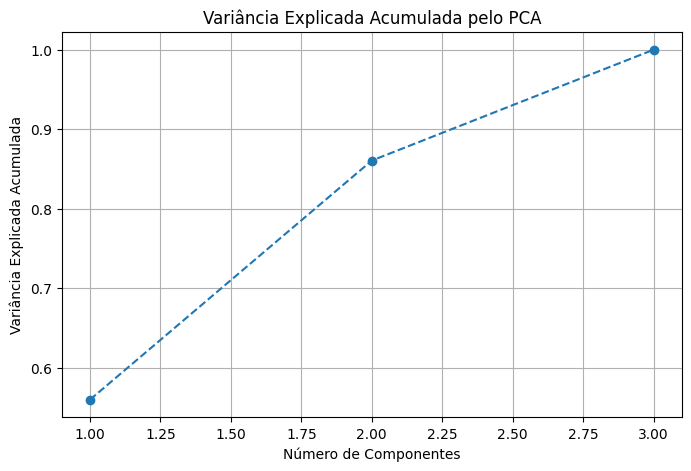

In [ ]:
# Aplicar o PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Plotar a variância explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid()
plt.show()

In [ ]:
# Criar um DataFrame com os componentes principais
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
pca_df.head()

,PC1,PC2,PC3
0,-1.250581,1.972492,0.314571
1,0.664489,-0.667714,-0.199878
2,-0.021059,-0.175201,-0.104430
3,-0.029213,-0.728563,-0.429840
4,-1.236523,1.828648,0.182457


## Cluster Hierárquico

Para visualizar a estrutura dos dados e obter uma ideia da quantidade ideal de clusters.

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

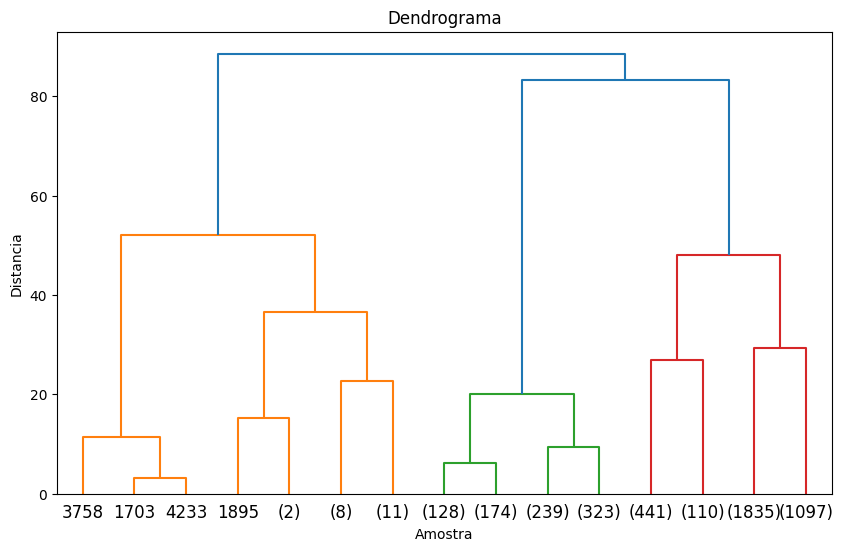

In [ ]:
 # Calcular a matriz de linkage
linkage_matrix = linkage(scaled_data, method='ward', metric='euclidean')


# Plotar o dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title('Dendrograma')
plt.xlabel('Amostra')
plt.ylabel('Distancia')
plt.show()


#single: Método da ligação simples (single linkage).
#complete: Método da ligação completa (complete linkage).
#average: Método da média (average linkage).
#centroid: Método do centróide (centroid linkage).

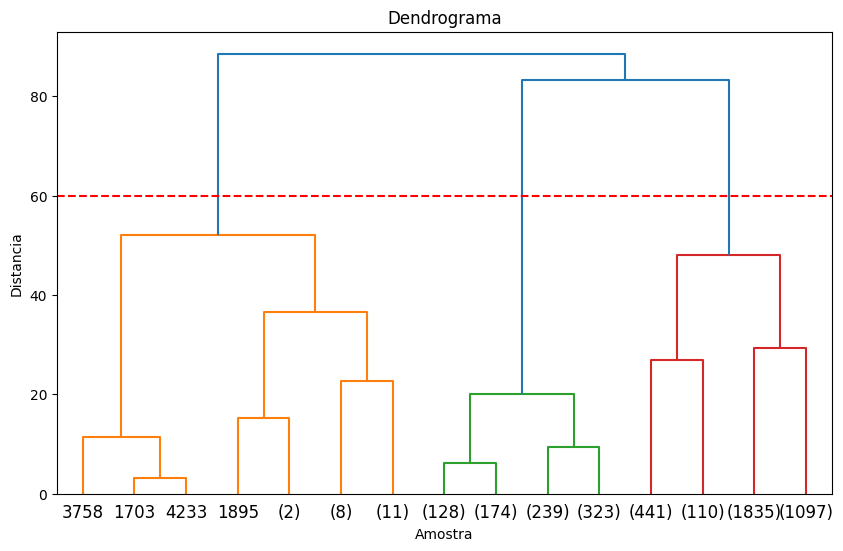

In [ ]:
# Calcular a matriz de linkage
linkage_matrix = linkage(scaled_data, method='ward', metric='euclidean')

# Plotar o dendrograma
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title('Dendrograma')
plt.xlabel('Amostra')
plt.ylabel('Distancia')
plt.axhline(y=60, color='r', linestyle='--') # Inclui a
plt.show()

In [ ]:
# Com base no dendrograma, escolher o número de clusters
chosen_num_clusters = 3

# Realizar o clustering hierárquico com o número escolhido de clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, chosen_num_clusters, criterion='maxclust')

In [ ]:
# Adicionar a coluna de grupos ao DataFrame original
rfm['Cluster'] = clusters

# Salvar o DataFrame com a marcação dos grupos
rfm.to_excel('clientes_com_grupos_hierarquicos.xlsx', index=False)

# Análise descritiva: média e quantidade de registros por grupo
grouped_summary = rfm.groupby('Cluster')[quantitative_data.columns].agg(['mean', 'count'])
print(grouped_summary)


            Recency        Frequency            Monetary      
               mean count       mean count          mean count
Cluster                                                       
1          5.360000    25  82.560000    25  78232.955600    25
2        269.133102   864   1.739583   864    450.109098   864
3         47.485788  3483   5.346827  3483   1709.832806  3483


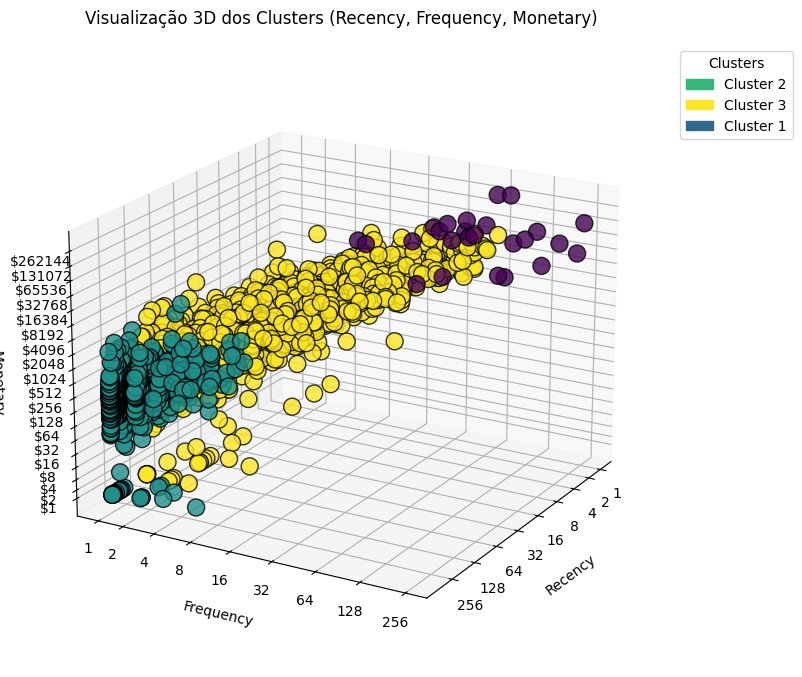

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import numpy as np

# Garantir que não haja valores negativos ou NaN
rfm['Recency'] = rfm['Recency'].clip(lower=1)
rfm['Frequency'] = rfm['Frequency'].clip(lower=1)
rfm['Monetary'] = rfm['Monetary'].clip(lower=1)
rfm = rfm.fillna(1)  # Substituir NaN por 1

# Calcular a escala logarítmica
rfm['Log_Recency'] = np.log1p(rfm['Recency'])
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['Monetary'])

# Configurar os dados
x = rfm['Log_Recency']
y = rfm['Log_Frequency']
z = rfm['Log_Monetary']
clusters = rfm['Cluster']

# Obter os clusters únicos e suas cores
unique_clusters = clusters.unique()
colors = plt.cm.viridis(unique_clusters / unique_clusters.max())

# Criar a figura e os eixos 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Ajustar o ângulo de visão
ax.view_init(elev=20, azim=30)

# Plotar os dados em 3D como esferas
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', s=150, alpha=0.8, edgecolor='k')

# Adicionar rótulos e título
ax.set_xlabel('Recency', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.set_zlabel('Monetary', labelpad=10)
ax.set_title("Visualização 3D dos Clusters (Recency, Frequency, Monetary)", pad=20)

# Configurar os ticks baseados em potências de 2
power_of_2_ticks_recency = [2**i for i in range(0, 9)]  # Potências de 2 até 256
power_of_2_ticks_frequency = [2**i for i in range(0, 9)]  # Potências de 2 até 256

# Gerar ticks para Monetary até o valor máximo
monetary_max = rfm['Monetary'].max()
power_of_2_ticks_monetary = [2**i for i in range(0, int(np.log2(monetary_max)) + 1)]

# Converter os ticks para escala logarítmica
log_ticks_recency = np.log1p(power_of_2_ticks_recency)
log_ticks_frequency = np.log1p(power_of_2_ticks_frequency)
log_ticks_monetary = np.log1p(power_of_2_ticks_monetary)

# Configurar os ticks e rótulos
ax.set_xticks(log_ticks_recency)
ax.set_yticks(log_ticks_frequency)
ax.set_zticks(log_ticks_monetary)

ax.set_xticklabels(power_of_2_ticks_recency)
ax.set_yticklabels(power_of_2_ticks_frequency)
ax.set_zticklabels([f"${val}" for val in power_of_2_ticks_monetary])  # Adicionar símbolo de dinheiro

# Criar a legenda manualmente
handles = [mpatches.Patch(color=plt.cm.viridis(cluster / unique_clusters.max()), label=f'Cluster {cluster}') for cluster in unique_clusters]
ax.legend(handles=handles, title="Clusters", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Mostrar o gráfico
plt.show()


## K-Means
Para segmentar os clientes de forma otimizada, com base na quantidade de clusters identificada no Cluster Hierárquico.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

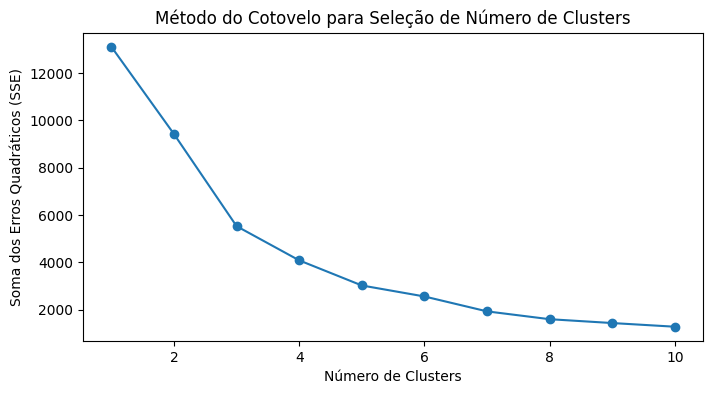

In [ ]:
# Encontrar o número ideal de clusters usando o método Elbow
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Erros Quadráticos (SSE)')
plt.title('Método do Cotovelo para Seleção de Número de Clusters')
plt.show()

In [ ]:
# Escolher o número de clusters com base na análise de  Cluster Hierárquico
chosen_num_clusters = 4

# Realizar a clusterização com o número escolhido de clusters
kmeans = KMeans(n_clusters=chosen_num_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

In [ ]:
# Adicionar a coluna de grupos ao DataFrame original
rfm['Cluster'] = clusters

# Análise descritiva: média e quantidade de registros por grupo
grouped_summary = rfm.groupby('Cluster')[quantitative_data.columns].agg(['mean', 'count'])
print(grouped_summary)

            Recency         Frequency             Monetary      
               mean count        mean count           mean count
Cluster                                                         
0          9.922680   194   28.510309   194   12168.264691   194
1        247.927577  1077    1.805942  1077     465.735293  1077
2          4.454545    11  109.909091    11  124312.306364    11
3         41.802913  3090    4.370550  3090    1321.577451  3090


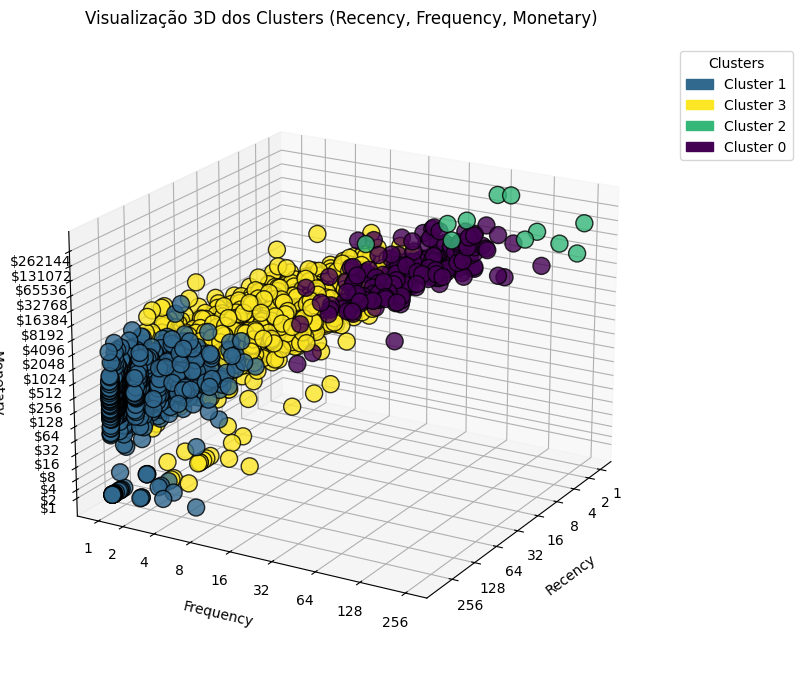

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import numpy as np

# Garantir que não haja valores negativos ou NaN
rfm['Recency'] = rfm['Recency'].clip(lower=1)
rfm['Frequency'] = rfm['Frequency'].clip(lower=1)
rfm['Monetary'] = rfm['Monetary'].clip(lower=1)
rfm = rfm.fillna(1)  # Substituir NaN por 1

# Calcular a escala logarítmica
rfm['Log_Recency'] = np.log1p(rfm['Recency'])
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['Monetary'])

# Configurar os dados
x = rfm['Log_Recency']
y = rfm['Log_Frequency']
z = rfm['Log_Monetary']
clusters = rfm['Cluster']

# Obter os clusters únicos e suas cores
unique_clusters = clusters.unique()
colors = plt.cm.viridis(unique_clusters / unique_clusters.max())

# Criar a figura e os eixos 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Ajustar o ângulo de visão
ax.view_init(elev=20, azim=30)

# Plotar os dados em 3D como esferas
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', s=150, alpha=0.8, edgecolor='k')

# Adicionar rótulos e título
ax.set_xlabel('Recency', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.set_zlabel('Monetary', labelpad=10)
ax.set_title("Visualização 3D dos Clusters (Recency, Frequency, Monetary)", pad=20)

# Configurar os ticks baseados em potências de 2
power_of_2_ticks_recency = [2**i for i in range(0, 9)]  # Potências de 2 até 256
power_of_2_ticks_frequency = [2**i for i in range(0, 9)]  # Potências de 2 até 256

# Gerar ticks para Monetary até o valor máximo
monetary_max = rfm['Monetary'].max()
power_of_2_ticks_monetary = [2**i for i in range(0, int(np.log2(monetary_max)) + 1)]

# Converter os ticks para escala logarítmica
log_ticks_recency = np.log1p(power_of_2_ticks_recency)
log_ticks_frequency = np.log1p(power_of_2_ticks_frequency)
log_ticks_monetary = np.log1p(power_of_2_ticks_monetary)

# Configurar os ticks e rótulos
ax.set_xticks(log_ticks_recency)
ax.set_yticks(log_ticks_frequency)
ax.set_zticks(log_ticks_monetary)

ax.set_xticklabels(power_of_2_ticks_recency)
ax.set_yticklabels(power_of_2_ticks_frequency)
ax.set_zticklabels([f"${val}" for val in power_of_2_ticks_monetary])  # Adicionar símbolo de dinheiro

# Criar a legenda manualmente
handles = [mpatches.Patch(color=plt.cm.viridis(cluster / unique_clusters.max()), label=f'Cluster {cluster}') for cluster in unique_clusters]
ax.legend(handles=handles, title="Clusters", loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Mostrar o gráfico
plt.show()


# Análise

escolher o melhor conjunto de clientes que a empresa deve atingir